테스트 환경설정

In [1]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
!git clone 'https://github.com/lhg010524/Detection_Abandoned-vehicle'
dist = distutils.core.run_setup("./Detection_Abandoned-vehicle/train_with_mask_rcnn/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
import sys, os
sys.path.insert(0, os.path.abspath('./Detection_Abandoned-vehicle/train_with_mask_rcnn/detectron2'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 8.2 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'Detection_Abandoned-vehicle'...
remote: Enumerating objects: 1020, done.
remote: Counting objects: 100% (1020/1020), done.
remote: Compressing objects: 100% (808/808), done.
remote: Total 1020 (delta 217), reused 970 (delta 191), pack-reused 0 (from 0)
Receiving objects: 100% (1020/1020), 1.09 MiB | 3.00 MiB/s, done.
Resolving deltas: 100% (217/217), done.
Ignoring dataclasses: markers 'python_version < "3.7"' don't

In [2]:
import sys
sys.path.insert(0, '/content/Detection_Abandoned-vehicle/train_with_mask_rcnn')

import detectron2

In [3]:
import sys, os
sys.path.insert(0, os.path.abspath('./Detection_Abandoned-vehicle/train_with_mask_rcnn'))
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.5 ; cuda:  cu121
detectron2: 0.6


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [5]:
from detectron2.data.datasets import register_coco_instances

# COCO 형식 데이터셋 등록
register_coco_instances("vehicle_train", {}, "/content/drive/MyDrive/detectron2/1024.json", "/content/drive/MyDrive/detectron2/data")# 메타데이터 가져오기
vehicle_metadata = MetadataCatalog.get("vehicle_train")

[12/10 05:25:30 d2.data.datasets.coco]: Loaded 51 images in COCO format from /content/drive/MyDrive/detectron2/1024.json


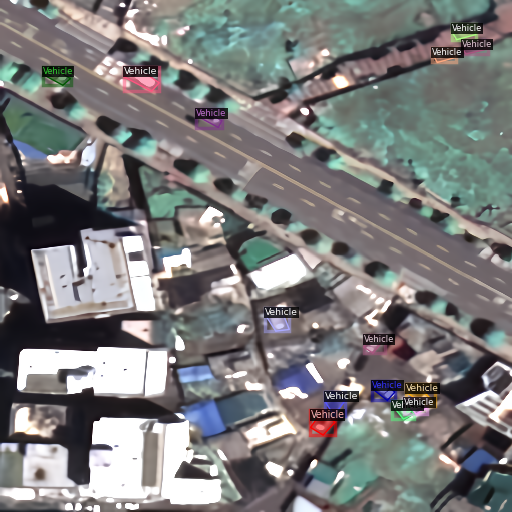

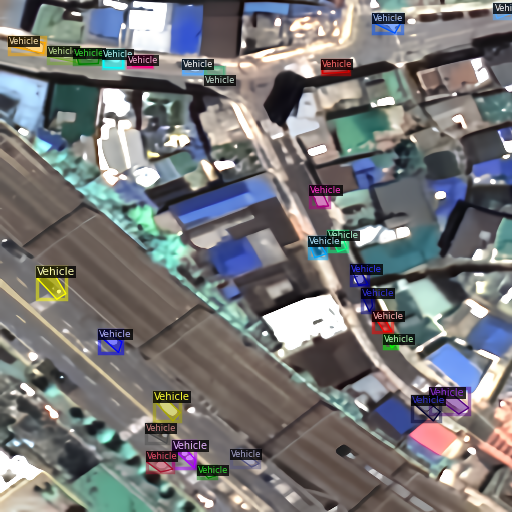

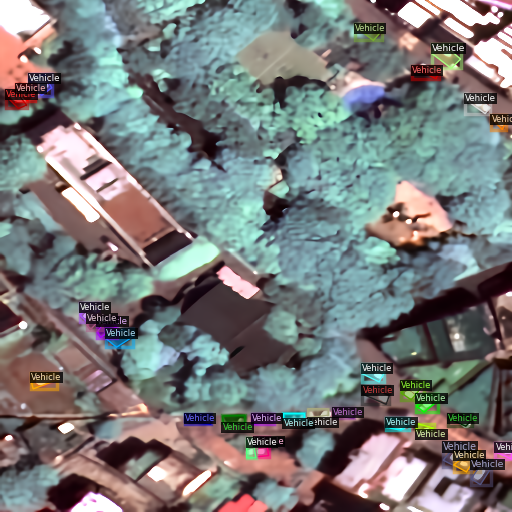

In [6]:
import random
import cv2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog
from google.colab.patches import cv2_imshow

# 등록된 COCO 데이터셋에서 정보 가져오기
dataset_dicts = DatasetCatalog.get("vehicle_train")
vehicle_metadata = MetadataCatalog.get("vehicle_train")

# 무작위로 3개의 이미지 시각화
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=vehicle_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [14]:
import os
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo


# Config 설정
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

# RoIHeads 설정 (Region of Interest 헤드의 배치 크기 및 클래스 수 설정)
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # RoIHead의 배치 크기 (기본값: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 차량 객체 탐지 (Vehicle 클래스 하나)

# 출력 디렉토리 설정 및 생성
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

In [ ]:
import csv
import os
import re
import numpy as np
import cv2
import shutil
from detectron2.engine import DefaultPredictor
from zipfile import ZipFile

# Helper function to extract latitude and longitude from filename
def extract_lat_lon(image_path):
    match = re.search(r"\(([-\d.]+)°, ([-\d.]+)°\)", image_path)
    if match:
        return float(match.group(1)), float(match.group(2))
    else:
        raise ValueError("이미지 제목에서 위경도를 추출할 수 없습니다.")

# Load images and perform inference for both dates
def process_image(cfg, image_path):
    im = cv2.imread(image_path)
    predictor = DefaultPredictor(cfg)
    outputs = predictor(im)

    # 바운딩 박스 중심 좌표 계산
    boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
    centers = [(int((box[0] + box[2]) / 2), int((box[1] + box[3]) / 2)) for box in boxes]

    return centers, boxes, im

# Convert pixel coordinates to latitude and longitude
def pixel_to_latlon(center, lat_center, lon_center, image_size, real_size):
    pixel_size = real_size / image_size  # 실제 크기 (미터) / 이미지 크기 (픽셀)
    lat_m_per_deg = 111320  # 위도 1도의 미터 단위
    lon_m_per_deg = 111320 * np.cos(np.radians(lat_center))  # 경도 1도의 미터 단위

    pixel_dx = center[0] - image_size // 2  # 중심에서의 x 방향 픽셀 거리
    pixel_dy = center[1] - image_size // 2  # 중심에서의 y 방향 픽셀 거리

    real_dx = pixel_dx * pixel_size  # x 방향 실제 거리 (미터)
    real_dy = pixel_dy * pixel_size  # y 방향 실제 거리 (미터)

    lat_offset = real_dy / lat_m_per_deg
    lon_offset = real_dx / lon_m_per_deg

    bbox_lat = lat_center + lat_offset
    bbox_lon = lon_center + lon_offset

    return bbox_lat, bbox_lon

# CSV 파일에 저장하는 함수
def save_to_csv(data, csv_filename):
    os.makedirs(os.path.dirname(csv_filename), exist_ok=True)  # 디렉터리가 없는 경우 생성
    with open(csv_filename, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(["Object ID", "Image Name", "Latitude", "Longitude", "X Coordinate", "Y Coordinate", "May Image Path", "June Image Path"])
        for row in data:
            writer.writerow([row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7]])

# 두 좌표가 오차 범위 내에 있는지 확인하는 함수
def is_within_threshold(coord1, coord2, threshold):
    distance = np.linalg.norm(np.array(coord1) - np.array(coord2))  # 유클리드 거리 계산
    return distance <= threshold

# 바운딩 박스 영역에서 평균 색상 추출
def extract_average_color(image, box):
    x1, y1, x2, y2 = map(int, box)
    cropped = image[y1:y2, x1:x2]  # 바운딩 박스 영역 자르기
    mean_color = cv2.mean(cropped)[:3]  # 평균 색상 (BGR 포맷)
    return mean_color

# 두 색상이 유사한지 비교하는 함수
def is_similar_color(color1, color2, threshold=50):
    diff = np.linalg.norm(np.array(color1) - np.array(color2))  # 유클리드 거리
    return diff <= threshold

# 두 날짜의 결과 비교 및 저장하는 메인 알고리즘 (업데이트)
def compare_and_save(cfg, folder_may, folder_june, csv_filename, output_folder):
    matched_coords = []
    object_id = 1
    os.makedirs(output_folder, exist_ok=True)  # 결과 이미지를 저장할 폴더 생성

    # 5월 폴더와 6월 폴더의 이미지 파일 목록 가져오기
    may_images = sorted([f for f in os.listdir(folder_may) if f.endswith(".png")])
    june_images = sorted([f for f in os.listdir(folder_june) if f.endswith(".png")])

    # 두 폴더의 이미지 파일 이름을 비교하여 같은 이름의 이미지 처리
    distance_threshold = 5  # 허용 오차 (픽셀 단위)
    color_threshold = 50  # 색상 차이 임계값

    for may_image in may_images:
        if may_image in june_images:
            image_path_may = os.path.join(folder_may, may_image)
            image_path_june = os.path.join(folder_june, may_image)

            # 위경도 추출
            lat_center, lon_center = extract_lat_lon(may_image)

            # 두 날짜 이미지에 대해 추론 수행
            centers_may, boxes_may, im_may = process_image(cfg, image_path_may)
            centers_june, boxes_june, im_june = process_image(cfg, image_path_june)

            # 같은 위치에 있는 객체 찾기 (오차 범위 및 색상 비교)
            for idx_may, (center_may, box_may) in enumerate(zip(centers_may, boxes_may)):
                color_may = extract_average_color(im_may, box_may)  # 5월 이미지 객체 색상 추출

                for idx_june, (center_june, box_june) in enumerate(zip(centers_june, boxes_june)):
                    color_june = extract_average_color(im_june, box_june)  # 6월 이미지 객체 색상 추출

                    # 좌표와 색상 비교
                    if is_within_threshold(center_may, center_june, distance_threshold) and is_similar_color(color_may, color_june, color_threshold):
                        # 중심 좌표로부터 위경도 계산
                        bbox_lat, bbox_lon = pixel_to_latlon(center_may, lat_center, lon_center, 1024, 128)  # 이미지 크기 및 실제 크기 설정

                        matched_coords.append((
                            object_id, may_image, bbox_lat, bbox_lon, center_may[0], center_may[1], image_path_may, image_path_june
                        ))

                        # 객체에 대한 정보 이미지에 표시 및 저장
                        x1, y1, x2, y2 = boxes_may[idx_may]

                        # 원본 이미지에 바운딩 박스 표시
                        cv2.rectangle(im_may, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)
                        cv2.rectangle(im_june, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

                        object_id += 1

            # 5월과 6월의 이미지 각각 저장 (바운딩 박스 표시된 전체 이미지 저장)
            may_object_path = os.path.join(output_folder, f"{may_image}_with_boxes_may.png")
            june_object_path = os.path.join(output_folder, f"{may_image}_with_boxes_june.png")
            cv2.imwrite(may_object_path, im_may)
            cv2.imwrite(june_object_path, im_june)

    # CSV 파일로 저장
    save_to_csv(matched_coords, csv_filename)

    # 이미지와 CSV 파일을 ZIP 파일로 압축
    zip_filename = f"{output_folder}.zip"
    with ZipFile(zip_filename, 'w') as zipf:
        # 이미지 파일 추가
        for foldername, subfolders, filenames in os.walk(output_folder):
            for filename in filenames:
                file_path = os.path.join(foldername, filename)
                zipf.write(file_path, os.path.relpath(file_path, output_folder))
        # CSV 파일 추가
        zipf.write(csv_filename, os.path.basename(csv_filename))

    print(f"All results have been zipped into {zip_filename}")

# 사용 예시
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # 테스트 단계에서의 임계값 설정

folder_may = "/content/drive/MyDrive/detectron2/5월"
folder_june = "/content/drive/MyDrive/detectron2/6월"
csv_filename = "/content/drive/MyDrive/dataset/matched_objects.csv"
output_folder = "/content/drive/MyDrive/dataset/matched_objects_images"

compare_and_save(cfg, folder_may, folder_june, csv_filename, output_folder)
print(f"Matching results saved to {csv_filename}")

[12/10 06:11:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/10 06:11:47 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/10 06:11:49 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/10 06:11:50 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/10 06:11:52 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/10 06:11:53 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/10 06:11:55 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/10 06:11:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/10 06:11:58 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

[12/10 06:12:00 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

All results have been zipped into /content/drive/MyDrive/dataset/matched_objects_images.zip
Matching results saved to /content/drive/MyDrive/dataset/matched_objects.csv
